**Description**: Test that priors make some sense and model fitting works.

**Estimated runtime**: ~30 min.

Note: I'm still learning how to do this type of analysis.

In [1]:
from typing import Literal

import arviz as az
import bambi as bmb
import numpy as np
import polars as pl
import seaborn as sns
import xarray as xr

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which number of test observations do you want to analyze?

In [3]:
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_home_dir = "accuracies_from_paper"

In [5]:
num_correct_df = utils.load_num_correct_all(accuracies_home_dir, num_test)

# Simulate data

Currently test that it doesn't detect a null effect.

TODO: repeat for a subtle, non-null effect.

In [6]:
method_prior_mean_std = (0, 0.001)
# method refers to the variable indicating treatment vs control

equation = "p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)"
id_vars = ["num_test", "pair", "lm_type", "dataset"]

In [7]:
model: bmb.Model = utils.stat_model(
    num_correct_df,
    treatment="test",
    control="extra",
    equation=equation,
    id_vars=id_vars,
    chains=2,
    dont_fit=True,
    method_prior_mean_std=method_prior_mean_std,
)

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):


In [8]:
model.build()

Fitting the model is so slow that I can only afford to check a few samples from the
prior, hence `draw=1`

In [9]:
random_seed = 123
idata_prior: az.InferenceData = model.prior_predictive(draws=1, random_seed=random_seed)

Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


In [10]:
prior: xr.DataArray = az.extract(idata_prior, group="prior_predictive")[
    "p(num_correct, num_test)"
]

# Turn simulated data into DF

Some data we'll need to populated the simulated DF:

In [11]:
datasets = num_correct_df["dataset"].unique(maintain_order=True)
num_subsamples = (
    num_correct_df.group_by(["lm_type", "dataset"])
    .count()
    .select("count")
    .head(n=1)
    .item()
)
lm_types = num_correct_df["lm_type"].unique(maintain_order=True)

Inverse of `melt` is `pivot`

In [12]:
# TODO: test this code for correctness
num_correct_df_simluated = (
    pl.DataFrame(
        {
            "num_test": num_test,
            "pair": np.repeat(np.arange(len(num_correct_df)), 2),  # 2=treatment,control
            "lm_type": np.tile(
                lm_types.to_numpy().repeat(datasets.len() * num_subsamples),
                reps=lm_types.len(),
            ).tolist(),
            "dataset": np.tile(
                datasets.to_numpy().repeat(num_subsamples * 2), reps=lm_types.len()
            ).tolist(),
            "method": np.tile(["control", "treatment"], reps=len(num_correct_df)),
            "num_correct": prior[:, 0].to_numpy(),
        }
    )
    .pivot(values="num_correct", index=id_vars, columns="method")
    .drop("pair")
)

# Visually check priors

Plot the distributions of the outcomes: the number of correct predictions.

I decided to adjust some priors—$\beta$
standard deviation, $\sigma_{D}, \sigma_{V}$—from $3.5355$ to
$1$ b/c the latter results in wide, basin-like outcomes.

This modification doesn't seem to affect the distribution of the posterior mean
($\beta$), i.e., it doesn't change the conclusions. It also didn't affect convergence
diagnostics—they're fine in both cases.

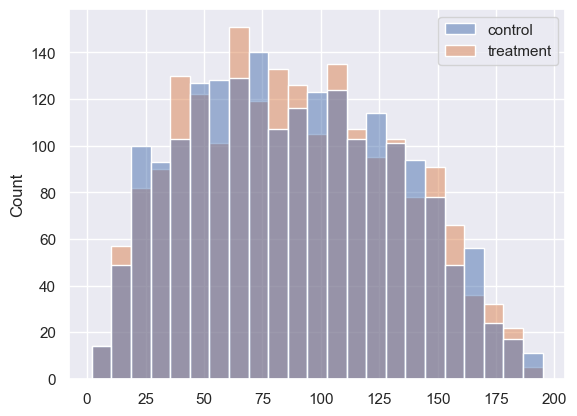

In [13]:
sns.histplot(num_correct_df_simluated.select(["control", "treatment"]).to_pandas());

# Test

Should not see an effect outside the range of (-0.01, 0.01) if the model makes sense and
the fit code is correct.

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1694 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[treatment],-0.001,0.005,-0.01,0.008,0.0,0.0,2026.0,1531.0,1.01


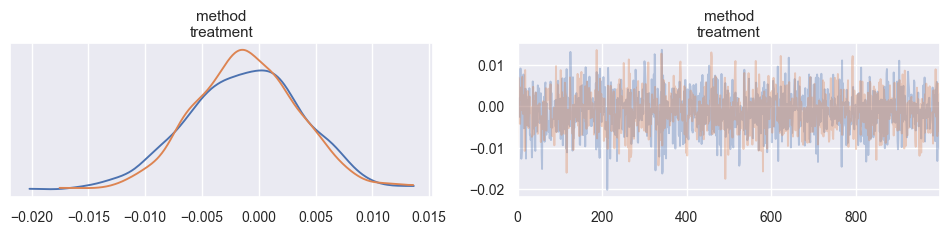

In [14]:
model, summary, az_summary = utils.stat_model(
    num_correct_df_simluated,
    treatment="treatment",
    control="control",
    equation=equation,
    id_vars=id_vars,
    chains=2,
)